# AIDM 7380 Recommender Systems for Digital Media
## Group Project
### Topic: Recipe Recommendation

***
* Group name:   Penguin <br/>

* Group members:<br/>
LEE Wang Ka, 19482124<br/>
CHIU Sing Yuk, 20431015<br/>
WANG Qilong, 20452454<br/>

***
### 1 - Background <br/>

**Purpose**

The recipe sites provide a platform for people to browse new recipes, learn the steps, or even share their own recipes. The recommender system in the recipe sites could help cookers to find the favourable recipes that they plan to cook or get new inspiration from fresh recipes. And the recipe sites hope to attract more people to their websites, increase the popularity and earn money from the advertisement and search engines. In order to become a popular and user-friendly websites, a good recommender system is required for winning people's hearts and impressing them with surprises.

**Feature**

The log file included the action of registered users towards the recipes. Therefore, the target in the recommendation is mainly focused on the registered users. Collaborative filtering of user- and item- based help the users to find the new fresh recipe that may fit their favour by similar users and items.


**User Behaviour - Implicit Feedback**

There are five types of implicit feedbacks including (1) view recipe, (2) short description, (3) steps, (4) long description and (5) view comments. For the user behaviour, the user must click on (1) view recipe first to enter the recipe browsing page, and they may do other actions to show their interests. They click on (2) short description for understanding the recipe ingredients; (3) steps for understanding the simple work flow of cooking; (4) long description for understanding every details of each steps and important cooking tips; (5) view comments for knowing the feedback of other user. The final goal is clicking on the long description, meaning that they plan to cook with this recipe and want to know every details. Therefore, the weighting of long description is the highest. The second highest weighting is short description as cookers want to know the components of the recipe when they are interested. The third one is view comments as people loves to see the recipe's comments when they are interested in the recipe and want to see how is the dish tastes. Followed by steps, steps is the basic exploration of the recipes and cooker usually click on steps to check if it is suitable to cook first. And view recipe is the basic step, therefore, there is no weighting for this action. The behaviour flow assumption are (1), followed by (2)/(3)/(4)/(5).

The weighting are:

* view recipe: 0
* steps: 5
* view comments: 30
* short description: 50
* long description: 100

There is no consideration on event count and time decay in this case. By analysis of the log file, there are no repeat action in every user-recipe. However, it only focused on current log file and difficulties would be faced when the future users have different user behaviours. It is one of the limitation in this recommendation.

***
### 2 - Data Exploration and Analysis on the Log File <br/>

In [1]:
import sys
import pandas as pd 
import numpy as np
!{sys.executable} -m pip install scipy
from scipy.spatial.distance import cosine

%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib
import matplotlib.pyplot as plt

In [2]:
recipe = pd.read_csv('../data/' + 'recipe_dataset2.csv')

In [3]:
recipe.head(20)

,Date,UserID,RecipeID,Event
0,2021-01-10 10:13:51,1319,2190,view_recipe
1,2021-01-10 10:14:55,890,217,view_recipe
2,2021-01-10 10:15:09,1319,2190,short_description
3,2021-01-10 10:15:19,1319,2190,steps
4,2021-01-10 10:15:22,890,217,short_description
5,2021-01-10 10:16:46,890,217,long_description
6,2021-01-10 10:17:03,1319,2190,view_comments
7,2021-01-10 10:18:52,890,217,steps
8,2021-01-10 10:20:38,1122,1934,view_recipe
9,2021-01-10 10:20:46,1461,4902,view_recipe


In [4]:
recipe.shape

(72068, 4)

In [5]:
recipe.columns

Index(['Date', 'UserID', 'RecipeID', 'Event'], dtype='object')

In [6]:
recipe.index

RangeIndex(start=0, stop=72068, step=1)

In [7]:
recipe.info

<bound method DataFrame.info of                       Date  UserID  RecipeID              Event
0      2021-01-10 10:13:51    1319      2190        view_recipe
1      2021-01-10 10:14:55     890       217        view_recipe
2      2021-01-10 10:15:09    1319      2190  short_description
3      2021-01-10 10:15:19    1319      2190              steps
4      2021-01-10 10:15:22     890       217  short_description
...                    ...     ...       ...                ...
72063  2021-03-09 15:21:00     315      3392        view_recipe
72064  2021-03-09 15:23:06     315      3392  short_description
72065  2021-03-09 15:23:14      82      4130  short_description
72066  2021-03-09 15:23:33     315      3392              steps
72067  2021-03-09 15:24:02      82      4130              steps

[72068 rows x 4 columns]>

In [8]:
recipe.describe()

,UserID,RecipeID
count,72068.000000,72068.000000
mean,1004.643476,2519.836196
std,576.784886,1438.166770
min,0.000000,0.000000
25%,507.000000,1273.000000
50%,1007.000000,2533.500000
75%,1507.000000,3762.000000
max,1999.000000,4999.000000


In [9]:
EventTypes = [
    'view_recipe',
    'short_description',
    'steps',
    'long_description',
    'view_comments'
] 
EventTypes

['view_recipe',
 'short_description',
 'steps',
 'long_description',
 'view_comments']

In [10]:
EventDict = {}

for Event in EventTypes:
    EventCount = (recipe['Event'] == Event).sum()
    EventDict[Event] = EventCount
EventDict

{'view_recipe': 19201,
 'short_description': 18230,
 'steps': 19201,
 'long_description': 9688,
 'view_comments': 5748}

<BarContainer object of 5 artists>

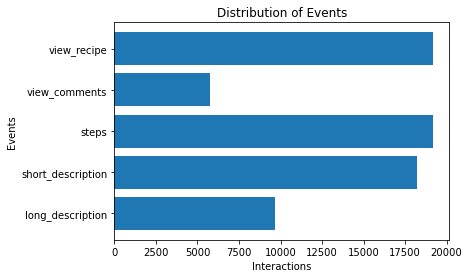

In [11]:
fig, ax = plt.subplots()
ax.set_ylabel('Events')
ax.set_xlabel('Interactions')
ax.set_title('Distribution of Events')
x,y = zip(*sorted(EventDict.items()))
fontsize = 10
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.barh(x,y)

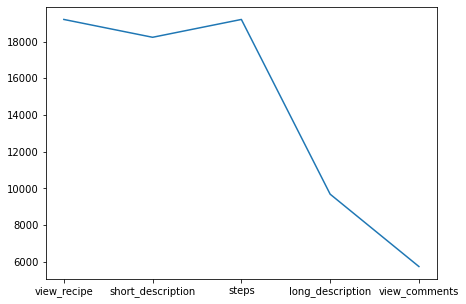

In [12]:
# Distribution of events
fig = plt.figure(figsize=(7,5)) 
plt.plot(list(EventDict.keys()),list(EventDict.values()))

In [13]:
# Most viewed on 'Long description'
LongdescriptionEvidence = recipe[recipe['Event'] == 'long_description']
LongdescriptionEvidence.head(10)

,Date,UserID,RecipeID,Event
5,2021-01-10 10:16:46,890,217,long_description
13,2021-01-10 10:22:12,1461,4902,long_description
14,2021-01-10 10:22:16,1122,1934,long_description
20,2021-01-10 10:34:44,1983,2607,long_description
26,2021-01-10 10:42:31,1985,3822,long_description
28,2021-01-10 10:43:47,293,4298,long_description
32,2021-01-10 10:45:28,1120,4991,long_description
48,2021-01-10 11:12:55,1803,3935,long_description
49,2021-01-10 11:13:01,1657,3911,long_description
56,2021-01-10 11:15:49,714,3362,long_description


In [14]:
LongdescriptionCount = LongdescriptionEvidence.groupby('RecipeID').Event.count() #count the event only "long_description" 
LongdescriptionCount

RecipeID
0       4
7       1
9       5
10      1
11      1
       ..
4992    1
4993    3
4994    2
4996    2
4997    3
Name: Event, Length: 3148, dtype: int64

In [15]:
LongdescriptionCount.sort_values(ascending = False, inplace = True)  #make an order, and choose the top 20 
LongdescriptionCount.head(20)

RecipeID
2317    9
2704    9
806     8
4828    8
340     8
3759    8
2473    8
949     8
1414    8
4365    8
3764    8
4665    8
743     8
490     8
4208    8
4855    8
768     8
2465    8
1435    8
1600    8
Name: Event, dtype: int64

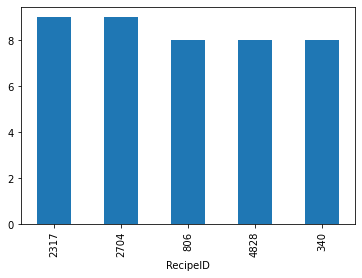

In [16]:
# The top 5 users that viewed the recipe with long description
#fig = plt.figure(figsize=(16,4)) 
LongdescriptionCount.head(5).plot(kind='bar')

***
### 3 - Collaborative Filtering <br/>

The main focus in this recommendation is collaborative filtering. Two methods are used including User-based and Item-based. It is because the user-item matrix is quite sparse, there are many limitations in the recommendation. The major solution is performing filtering of users and items with some criteria to achieve the right recommendation and prediction. Therefore, there are a lot of users and items that cannot include in the calculation and there is no recommendation to them. It may need to solve by other recommendation method, like content-based recommendation.



### 3.1 - User-based Collaborative Filtering

People may have tendency to cook a type of food and favour to one country's cuisine. For example, baker loves cake and dessert, Chinese loves Asian food and vegetarian prefers vegan diet. Therefore, user-based collaborative filtering could help users to find some new recipe that is based on someone having the similar favour.

***
**Filtering**

<br/>

***Problem (1) - Sparsity***

The sparsity value is calculated by the number of cells that contain no rating divided by the total number of cells. The sparsity value of this matrix is 99.7% which means the active users only browse a small portion of recipes. In which, the prediction result may become monotonic to the users who browsed less recipes. In order to increase the accuracy of the prediction, selection would be performed to eliminate some users who browsed a small number of recipes. Unfortunately, the user-based collaborative filtering may not work of those users.

***Solution (1) - Overlapping User***

A overlapping user-user matrix is set up to see how many co-viewed recipes between two users by multiplying transposed Boolean matrix and Boolean matrix. At least 3 co-viewed recipes is set. This can help to eliminate users with less overlapping recipes to other users.

<br/>

***Problem (2) - 2 Co-viewed Recipes in Pearson Correlation***

For the calculation of users similarity, Pearson correlation is used. Only 2 co-viewed recipes between users for calculating the Pearson correlation generates either 1 or -1. However, it does not mean it is perfectly correlated, just because it cannot count the correlation between two points. And the 1 value would affect the similar users ranking. Therefore, the 2 co-viewed recipes are dropped.

***Solution (2) - Set Up Threshold and Conditional Statement***

Threshold is set up to filter the 2 co-viewed recipes. One important to address is that there are users having at least 3 co-viewed recipes and their ratings may be perfectly the same and give the result 1 and this perfect coherent cannot be omitted by simply filtering the similarity value 1.

<br/>

***Problem (3) - NA and Negative Correlation***

As the dataset is relative sparse and there is less similar users are found. Normally, the sorting of the similarity of the similar user would bring positively correlation value to the top in a denser dataset and there is less chance to see the negatively correlated user in the top rank of the list. The selection of no correlated or negatively correlated users are meaningless for recommendation.

***Solution (3) - Elimination of No and Negatively Correlated Users***

Users with NA value and negative value are dropped in the correlation dataframe. And no recommendation would make based on those users.

<br/>

**Limitation**

The number of users fitting the filtering are extremely small because of the sparse dataset. Therefore, this recommendation method can only fit a small part of the users. Unfortunately, most of the users cannot benefit from the User-based recommendation.


In [17]:
users = recipe.UserID.unique()
content = recipe.RecipeID.unique()
print(len(content))
print(len(users))

3504
2000


In [18]:
# Create a user-item matrix
uiMatrix = pd.DataFrame(columns=content, index=users)
uiMatrix

,2190,217,1934,4902,2607,3822,4298,4991,4651,2722,...,4567,840,1776,618,2493,417,4659,3248,1740,3729
1319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Get the event types

eventTypes = recipe.Event.unique()
print(eventTypes)

['view_recipe' 'short_description' 'steps' 'long_description'
 'view_comments']


In [20]:
# Hope to get some ideas on weighting by counting the frequency of events

eventDict = {}

# Count every event frequency
for event in eventTypes:
    eventCount = (recipe['Event'] == event).sum()
    eventDict[event] = eventCount
eventDict

{'view_recipe': 19201,
 'short_description': 18230,
 'steps': 19201,
 'long_description': 9688,
 'view_comments': 5748}

In [21]:
# For checking
case = recipe[(recipe['RecipeID'] == 453)]
case

,Date,UserID,RecipeID,Event
16267,2021-01-23 15:08:11,1665,453,view_recipe
16268,2021-01-23 15:10:08,1665,453,short_description
16269,2021-01-23 15:12:07,1665,453,long_description
16271,2021-01-23 15:14:40,1665,453,steps
16272,2021-01-23 15:15:08,1665,453,view_comments
19000,2021-01-25 17:18:46,1454,453,view_recipe
19005,2021-01-25 17:21:26,1454,453,short_description
19006,2021-01-25 17:22:21,1454,453,long_description
19007,2021-01-25 17:23:53,1454,453,steps
19009,2021-01-25 17:26:46,1454,453,view_comments


In [22]:
# Give the weighting

eventWeights = {
    'view_recipe': 0,
    'short_description': 50,
    'steps': 5,
    'long_description': 100,
    'view_comments': 30}

In [23]:
# Iterate the evidence
for index, row in recipe.iterrows():
    # Select the user and items involved
    currentUser = row['UserID']
    currentContent = row['RecipeID']
    
    # Extract the appropriate weight for the event
    w = eventWeights[row['Event']]
    
    # Find the value eventually stored for the current user-item combination
    currentValue = uiMatrix.at[currentUser, currentContent]
    if np.isnan(currentValue):
        currentValue = 0
        
    # Compute the new value and update the user-item matrix
    updatedValue = currentValue + w #+ (1 * w)
    uiMatrix.at[currentUser, currentContent] = updatedValue

In [26]:
# Compute sparsity value of the matrix

# Number of possible ratings
matrixSize = uiMatrix.shape[0]*uiMatrix.shape[1]

# Number of na elements
matrixNA = uiMatrix.isna().sum().sum()

# Sparsity value
uiMatrixSparsity = matrixNA / matrixSize
uiMatrixSparsity

0.9972601312785389

In [27]:
uiMatrix = uiMatrix.astype(float)

In [28]:
min_value = np.nanmin(uiMatrix.values)
max_value = np.nanmax(uiMatrix.values)

In [29]:
# Normalization of the whole matrix
uiMatrixNorm = uiMatrix.apply(
    lambda x: ((x - min_value)/(max_value - min_value)) * 10)

In [30]:
uiMatrixNorm

,2190,217,1934,4902,2607,3822,4298,4991,4651,2722,...,4567,840,1776,618,2493,417,4659,3248,1740,3729
1319,4.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,NaN,NaN,NaN,8.333333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,8.333333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Because if the users only have two co-interested recipe, the pearson correlation would be either 1 or -1
# The 1 from only two co-interested recipe, would affect the similarity result which burden the three or more co-interested recipe 
# As mostly it is hard to reach 1, perfect similar, but we still cannot omit this possibility by dropping all 1 value
# Therefore, need a overlapping matrix to eliminate the users with less overlapping recipes to other users

def to_bool(value):
    if np.isnan(value):
        return 0
    else:
        return 1

In [32]:
uiMatrixBool = uiMatrix.applymap(lambda x: to_bool(x))
uiMatrixBool

,2190,217,1934,4902,2607,3822,4298,4991,4651,2722,...,4567,840,1776,618,2493,417,4659,3248,1740,3729
1319,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
890,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1122,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1461,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Make the user-user overlapping
overlappingRecipes = uiMatrixBool.dot(uiMatrixBool.T)

In [34]:
# 1 represents there are one co-viewed recipes, our target is at least have 3 co-viewed recipes 
overlappingRecipes

,1319,890,1122,1461,1983,1985,293,1120,294,205,...,993,1615,53,230,648,1938,517,60,9,1316
1319,10,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
890,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1122,0,0,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1461,1,0,0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,0,0,0,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0


In [35]:
# haha = overlappingRecipes.loc[1300]
# haha.to_frame()
# haha[haha>2]
# newList = []
# if haha[haha>2].count() > 1:
#     #newList.append(64)
# newList

In [36]:
# Make the user list
usersList = overlappingRecipes.columns

In [37]:
# Make the new user list to store the suitable user
newList = []

# Loop to access every user
for user in usersList:
    lookUser = overlappingRecipes.loc[user]
    
    # Convert series to df
    lookUser.to_frame()
    
    # The number of the dataframe is how many co-viewed recipes between two users
    # 2 co-viewed recipes generates either 1 or -1 in Pearson correlation
    # The 1 would affect the ranking of similar user
    # Therefore, our target is at least having 3 co-viewed recipes
    # We can also adjust the coViewThreshold
    # Because the df include the 'self'-recipe, therefore, the counting should be over 1
    coViewThreshold = 2
    if lookUser[lookUser > coViewThreshold].count() > 1:
        newList.append(user)

In [38]:
newList

[1461,
 1300,
 475,
 1434,
 1479,
 1248,
 39,
 143,
 273,
 1735,
 1651,
 775,
 1946,
 943,
 961,
 868,
 503,
 446,
 1566,
 587,
 191,
 1480]

In [39]:
# Make a new User-Item Matrix with the user who pass the threshold
uiMatrixTh = uiMatrixNorm.loc[newList]

In [40]:
# Drop recipes that no threshold-user viewed
uiMatrixTh = uiMatrixTh.dropna(axis = 'columns', how = 'all')

In [41]:
# Compute sparsity value of the matrix

# Number of possible ratings
matrixSize = uiMatrixTh.shape[0]*uiMatrixTh.shape[1]

# Number of na elements
matrixNA = uiMatrixTh.isna().sum().sum()

# Sparsity value
uiMatrixSparsity = matrixNA / matrixSize
uiMatrixSparsity

0.945998445998446

In [42]:
# For checking
#uiMatrixTh.loc[943].dropna().sort_index()

In [43]:
# def generateMatrixWithThreshold(df):
    
#     uiMatrixBool = df.applymap(lambda x: to_bool(x))
    
#     # Make the user-user overlapping
#     overlappingRecipes = uiMatrixBool.dot(uiMatrixBool.T)
    
#     # Make the user list
#     usersList = overlappingRecipes.columns
    
#     # Make the new user list to store the suitable user
#     newList = []

#     # Loop to access every user
#     for user in usersList:
#         lookUser = overlappingRecipes.loc[user]
    
#         # Convert series to df
#         lookUser.to_frame()
    
#         # The number of the dataframe is how many co-viewed recipes between two users
#         # 2 co-viewed recipes generates either 1 or -1 in Pearson correlation
#         # The 1 would affect the ranking of similar user
#         # Therefore, our target is at least having 3 co-viewed recipes
#         # We can also adjust the coViewThreshold
#         # Because the df include the 'self'-recipe, therefore, the counting should be over 1
#         coViewThreshold = 2
#         if lookUser[lookUser > coViewThreshold].count() > 1:
#             newList.append(user)
            
#     # Make a new User-Item Matrix with the user who pass the threshold
#     uiMatrixTh = df.loc[newList]
    
#     # Drop recipes that no threshold-user viewed
#     uiMatrixTh = uiMatrixTh.dropna(axis = 'columns', how = 'all')
    
#     # return a User-Item Matrix that pass the threshold, and the list of users that are capable to do correlation test
#     return uiMatrixTh, newList

In [44]:
def userCF_prediction(df, currentUser, numUsers, numItems):

    # Convert to float
    df = df.astype(float)
    
    # Normalization within user to get the adjusted rating
    uiMatrix = df.sub(df.mean(axis=1), axis=0)
    
    # Find the current user in matrix
    cuDf = uiMatrix.loc[currentUser]

    # Perform the pearson correlation between current user to every user
    corrDf = uiMatrix.corrwith(cuDf, axis=1, method='pearson')
    
    # Drop the NA value, avoid it get into the ranking when there is few user with similarity value
    corrDf = corrDf.dropna()
    
    # Drop the current user from the df
    corrDf.drop(labels=[currentUser], inplace=True)
    
    # Convert to dataframe for below filtering steps
    corrDfNew = corrDf.to_frame()
    
    # There are users who co-viewed only two recipes and the value would be either 1 or -1 due to the Pearson correlation
    # We want to find out the users who having 1 or -1 value and make a list 
    checkingList = corrDfNew.loc[corrDfNew[0] == 1].index
    checkingList = checkingList.append(corrDfNew.loc[corrDfNew[0] == -1].index)
    
    # However, there are users having at least three co-viewed recipes and their ratings maybe perfectly the same
    # This condition will also give value 1, and we cannot omit this perfect coherent
    # Therefore, we need to find out the number of co-viewed recipes
    # Keeping the co-viewed recipes with > 2
    # Dropping the co-viewed recipes with 2
    
    # Find the recipes that viewed by current user
    cuDfIndex = uiMatrix.loc[currentUser].dropna().index 
    
    # Loop for looping the checking list which is users with 1 or -1
    for checkUser in checkingList:
        
        # Get the target user recipes list
        cuDf1 = uiMatrix.loc[checkUser]
        cuDfIndex1 = cuDf1.dropna().index   

        # Get the co-viewed recipes and count for it
        coView = set(cuDfIndex) & set(cuDfIndex1)
        freq = len(coView)
        
        # Conditional statment for number of co-viewed recipes, drop with only 2 co-viewed
        if freq == 2:
            corrDf = corrDf.drop(labels = checkUser)
            
    # In the Pearson correlation, users with value ≤ 0 have no correlation or have totally different tastes
    # Therefore, we would like to drop the negative (unlike-users) in this sparse dataset, as they may place in top rank
    corrDf = corrDf.where(corrDf > 0)
    corrDf = corrDf.dropna()

    # Get the top user 
    corrDf = corrDf.head(numUsers)
    
    # Get the un-viewed recipes of current user
    toPredict = cuDf[cuDf.isna()]
    
    # Get the ratings of the similar users
    ratings = uiMatrix.loc[corrDf.index]
    
    # Get the recipes we wanted in the similar users df
    ratingsToPredict = ratings[toPredict.index]

    # Get the mean rating from the similar users
    predictedRatings = ratingsToPredict.mean()
    
    # Sort from highly favourable
    predictedRatings.sort_values(ascending=False, inplace=True)
    
    # Back to the current user case
    cuAvgRating = df.loc[[currentUser]].dropna(axis=1).mean(axis=1)
    predictedRatings += cuAvgRating.iloc[0]
    
    # Result
    prediction = predictedRatings.head(numItems)
    
    return corrDf, prediction

In [45]:
print('This is the list of user that are able to do the correlation test:' + str(newList))
print('However, all of them are only having one other user to do the corrleation test because of the sparse dataset. And some of the similar user are having negative correlation and there is no recommendation for them.')

This is the list of user that are able to do the correlation test:[1461, 1300, 475, 1434, 1479, 1248, 39, 143, 273, 1735, 1651, 775, 1946, 943, 961, 868, 503, 446, 1566, 587, 191, 1480]
However, all of them are only having one other user to do the corrleation test because of the sparse dataset. And some of the similar user are having negative correlation and there is no recommendation for them.


In [46]:
currentUser = 1434
numUsers = 2
numItems = 5

In [50]:
result = userCF_prediction(uiMatrixTh, currentUser, numUsers, numItems)

In [51]:
# Correlation Dataframe
result[0]

1461    0.731307
dtype: float64

In [52]:
# If there is no suitable user for recommendation (empty in correlation dataframe), the statement would print out

if result[0].empty == True:
    
    print('Sorry that there is no users having similar tastes with you currently. And no recommendation can be provided for you.')
    
    test = 0

else:
    
    test = 1

In [53]:
# print the answer if there is recommendation for that user

if test == 0:
    
    print('No recommendation for you.')

elif test == 1:
    
    print('For the number ' + str(currentUser) + ' user, the Top ' + str(numItems) + ' recommended items and the prediction rating are:')
      
    print(result[1])

For the number 1434 user, the Top 5 recommended items and the prediction rating are:
4067    9.603989
3447    9.603989
3024    9.603989
1397    9.603989
4902    9.603989
dtype: float64


### 3.2 - Item-based Collaborative Filtering

People may want to find similar recipes that they liked. Gathering the recipes with similar rating helps to find the similar recipes based on people's favour. Therefore, item-based collaborative filtering could help users to find some new recipe that is based on similar rating recipes.

***
**Filtering**

<br/>

***Problem (1) - Sparsity***

The same issue happens on the item-based CF. The sparse dataset makes the calculation heavy and calculates many not suitable correlation. In order to save the calculation time, selection would be performed to eliminate some recipes which was browsed by single users. Unfortunately, the item-based collaborative filtering may not work of those recipes.

***Solution (1) - Overlapping Recipes***

A overlapping item-item matrix is set up to see how many users co-rated the two recipes by multiplying Boolean matrix and transposed Boolean matrix. At least 2 co-viewed recipes is set. This can help to eliminates recipes with less co-viewed user.

<br/>

***Problem (2) - Coverage***

Normally, there are around 5-10 similar item recommendation based on the current item. However, in this sparse dataset, there are less similar items and usually can only recommend one or two items. The further selection on number of similar items needed to be included would greatly reduce the items for recommendation.

***Solution (2) - Un-limit the Number of Similar Items***

There is no limitation on the similar items needed to be provided. It is because the coverage of User-based CF is already very low. Although there are only one to two recommended similar items, it is better than further lowing the coverage

<br/>

***Problem (3) - Negative Similarity***

As the dataset is relative sparse and there is less similar items are found. The selection of negatively-similar items are meaningless for recommendation.

***Solution (3) - Elimination of Negatively Similar Users***

Items with negative similarity value are dropped in the correlation dataframe. And no recommendation would make based on those items.

<br/>

**Limitation**

The biggest limitation is the number of similar items provided are small. Only one to two items can be recommended to the user based on one item. The increase of users and their view towards more recipes can resolve this problem.



In [55]:
def cosine_sim(df1, df2):
    # check for na in dataframes
    df1na = df1.isna()
    df1clean = df1[~df1na]
    df2clean = df2[~df1na]

    df2na = df2clean.isna()
    df1clean = df1clean[~df2na]
    df2clean = df2clean[~df2na]

    
    # Compute cosine similarity
    distance = cosine(df1clean, df2clean)
    sim = 1 - distance
    
    return sim

In [56]:
uiMatrixNorm = uiMatrixNorm.astype(float)

In [57]:
# Make boolean matrix
uiMatrixBool = uiMatrixNorm.applymap(lambda x: to_bool(x))
uiMatrixBool

,2190,217,1934,4902,2607,3822,4298,4991,4651,2722,...,4567,840,1776,618,2493,417,4659,3248,1740,3729
1319,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
890,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1122,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1461,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1983,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Transpose and get the ovelapping item-item matrix
overlappingUsersRatings = uiMatrixBool.T.dot(uiMatrixBool)
overlappingUsersRatings

,2190,217,1934,4902,2607,3822,4298,4991,4651,2722,...,4567,840,1776,618,2493,417,4659,3248,1740,3729
2190,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217,0,9,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1934,0,1,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4902,0,0,0,10,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2607,0,0,0,0,10,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [59]:
overlappingUsersRatings.max(axis=0).min()

1

In [60]:
overlappingUsersRatings.shape

(3504, 3504)

In [61]:
# Get empty item-item matrix 
iiSimMatrix = pd.DataFrame().reindex_like(overlappingUsersRatings)

In [62]:
iiSimMatrix

,2190,217,1934,4902,2607,3822,4298,4991,4651,2722,...,4567,840,1776,618,2493,417,4659,3248,1740,3729
2190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# Get the adjusted rating by substracting the users' mean
uiMatrixSub = uiMatrixNorm.sub(uiMatrixNorm.mean(axis=1), axis=0)

In [64]:
# Extract the recipes' list
recipesToPrecompute = iiSimMatrix.columns

#Extract the item's pair ratings from dataframe
for item1 in recipesToPrecompute:
    item1Ratings = uiMatrixSub[item1]
    for item2 in recipesToPrecompute:
        item2Ratings = uiMatrixSub[item2]
        
        # If there is overlapping of rating then precompute the cosine similarity
        # Here you can modify the threshold of minimum overlapping ratings 
        # We set the threshold to 1, it is the minimum overlapping rating
        threshold = 1
        
        # Two recipes get at least two co-viewed from the users pass to the iiSimMatrix
        if overlappingUsersRatings.at[item1,item2] > threshold:
            iiSimMatrix.at[item1, item2] = cosine_sim(item1Ratings, item2Ratings)

In [65]:
# Find recipes that get calculated cosine similarity and add to the new list
selectedRecipeList = []

# Becuase there are self-recipes similarity value that account for one spot, therefore set the threshold to at least 2
# If we only want to suggest item that have more than one similar items, we can increase the threshold value
# However, in this sparse dataset, we want to increase the coverage of the items 
# as the coverage in user-based is already very low
for recipes in recipesToPrecompute:
    if iiSimMatrix[recipes].dropna().count() > 1:
        selectedRecipeList.append(recipes)

In [66]:
# A list to display the items that are having similar items and be able to do recommendation
for recipes in selectedRecipeList:
    print('Target Item: ' + str(recipes))
    print(iiSimMatrix[recipes].dropna())
    print('-----------------------')

Target Item: 2190
2190    1.000000
1771    0.985238
Name: 2190, dtype: float64
-----------------------
Target Item: 217
217     1.000000
3483   -0.201972
1663   -0.918539
Name: 217, dtype: float64
-----------------------
Target Item: 4902
4902    1.000000
81     -0.960013
2715   -0.940158
2004   -0.885886
4951   -0.334711
Name: 4902, dtype: float64
-----------------------
Target Item: 2607
2607    1.000000
2957    0.686813
130     0.138637
Name: 2607, dtype: float64
-----------------------
Target Item: 4298
4298    1.000000
2317    0.845467
Name: 4298, dtype: float64
-----------------------
Target Item: 4651
4651    1.000000
1232    0.247117
Name: 4651, dtype: float64
-----------------------
Target Item: 2722
2722    1.000000
368     0.765238
Name: 2722, dtype: float64
-----------------------
Target Item: 3911
3911    1.000000
815    -0.722036
1655    1.000000
Name: 3911, dtype: float64
-----------------------
Target Item: 445
445     1.000000
3106   -0.989087
2223   -0.833223
509    -

In [ ]:
# iiSimMatrix[4577].dropna()

In [67]:
# Make the new iiSimMatrix with the items that passed the filtering 
iiSimMatrixSelect = iiSimMatrix.loc[selectedRecipeList]
iiSimMatrixSelect = iiSimMatrixSelect.dropna(axis = 1, how = 'all')
iiSimMatrixSelect

,2190,217,4902,2607,4298,4651,2722,3911,445,3362,...,846,71,1683,3434,3476,3816,3053,3892,2612,4777
2190,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4902,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2607,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [68]:
# Input user
currentUser = 1461

In [69]:
# Get the recipes that previously rated by the current user
cuRatedRecipes = uiMatrixSub.loc[currentUser].dropna().sort_values(ascending=False)
cuRatedRecipes

4067    2.851852
3447    2.851852
3024    2.851852
1397    2.851852
4902    2.851852
3011    1.740741
3256   -1.037037
138    -1.037037
81     -1.037037
3741   -1.037037
4919   -1.037037
1192   -2.703704
1568   -2.703704
2564   -2.703704
2619   -2.703704
Name: 1461, dtype: float64

In [70]:
# As we performed filtering of item, not every item is in the iiSimMatrix
# We need to get the items that are existing in both the current user rated item list and iiSimMatrix list
# Get the item that is inside iiSimMatrixSelect
cuItemInSelectedList = list(set(cuRatedRecipes.index).intersection(selectedRecipeList))

In [71]:
cuItemInSelectedList

[1568, 2564, 4902, 3024, 81, 4919, 2619, 3741]

In [72]:
# Select the item in the current user list
cuRatedRecipes = cuRatedRecipes.loc[cuItemInSelectedList].sort_values(ascending=False)

In [73]:
cuRatedRecipes

3024    2.851852
4902    2.851852
3741   -1.037037
4919   -1.037037
81     -1.037037
2619   -2.703704
2564   -2.703704
1568   -2.703704
Name: 1461, dtype: float64

In [74]:
# Use one of the item for item-item prediction as currentItem
currentItem = cuRatedRecipes.head(1).index
currentItem = currentItem[0]

In [75]:
# Find the current item in the similarity matrix to get the other similiar items
recommendationList = iiSimMatrixSelect[currentItem].dropna().sort_values(ascending=False)

In [76]:
recommendationList

3024    1.000000
474     0.632877
453     0.206916
3691   -0.103451
2619   -0.863372
Name: 3024, dtype: float64

In [77]:
recommendationList.index

Int64Index([3024, 474, 453, 3691, 2619], dtype='int64')

In [78]:
# There are item that previously rated by the current user already
# We need to drop those items by finding the intersect recipes in user list and similar item list
ratedItem = list(set(cuRatedRecipes.index).intersection(recommendationList.index))

In [79]:
ratedItem

[3024, 2619]

In [80]:
# Drop the item that already rated by the current user
recommendationList.drop(labels=ratedItem, inplace=True)
recommendationList

474     0.632877
453     0.206916
3691   -0.103451
Name: 3024, dtype: float64

In [81]:
# Because our dataset is sparse, there are less positively correlated item
# We need to drop the item with negative similarity value, as those items are not getting similar rating but opposite
recommendationList = recommendationList.where(recommendationList > 0)
recommendationList = recommendationList.dropna()
recommendationList = recommendationList.head(3)

In [82]:
recommendationList

474    0.632877
453    0.206916
Name: 3024, dtype: float64

In [83]:
# For some items that may only have negatively correlated item, there are no recommendation for them
if recommendationList.empty == True:
    print('Sorry, there is no items recommend for you.')

In [84]:
# Get the user-item matrix with the target items that waiting to be predicted
itemsToCompare = uiMatrixSub[recommendationList.index]
itemsToCompare

,474,453
1319,NaN,NaN
890,NaN,NaN
1122,NaN,NaN
1461,NaN,NaN
1983,NaN,NaN
...,...,...
1938,NaN,NaN
517,NaN,NaN
60,NaN,NaN
9,NaN,NaN


In [85]:
# Confirming
predictedRating = itemsToCompare.loc[currentUser].mean()
predictedRating

nan

In [86]:
# Get the selected item with the user-item matrix
itemsToCompare = uiMatrixSub[recommendationList.head(3).index]
itemsToCompare

,474,453
1319,NaN,NaN
890,NaN,NaN
1122,NaN,NaN
1461,NaN,NaN
1983,NaN,NaN
...,...,...
1938,NaN,NaN
517,NaN,NaN
60,NaN,NaN
9,NaN,NaN


In [87]:
# Get the mean vlaue of the target similar item
predictedRatings = itemsToCompare.mean(axis=0)
predictedRatings.sort_values(ascending=False, inplace=True)
predictedRatings

453    0.987741
474   -0.283970
dtype: float64

In [88]:
# Calculate the adjusted rating
cuAvgRating = uiMatrixNorm.loc[[currentUser]].dropna(axis=1).mean(axis=1)
cuAvgRating

1461    5.481481
dtype: float64

In [89]:
# Back to the current user case, add back the adjusted rating
predictedRatings += cuAvgRating.iloc[0]
predictedRatings

453    6.469222
474    5.197511
dtype: float64

***
### 4 - Evaluation <br/>

The recommendation method is based on Pearson correlation in User-based CF and Cosine Similarity in Item-based CF. The filtering is the biggest challenges, and the filtering method can affect the accuracy of recommendation and prediction. An evaluation method - Mean Absolute Error (MAE) are used to evaluate the predicted rating and actual rating. Due to the time-limit, only user-based CF performed the evaluation part.

In [100]:
recommendPredictedRatings = result[1]
recommendPredictedRatings

4067    9.603989
3447    9.603989
3024    9.603989
1397    9.603989
4902    9.603989
dtype: float64

In [99]:
corrDf = result[0]
corrDf

1461    0.731307
dtype: float64

In [91]:
# Pull out the user-item matrix with recommend predicted rating
uiMatrixNormitemN = uiMatrixNorm[recommendPredictedRatings.index]

# Rewrite the top item rating to the current user's row
for index in recommendPredictedRatings.index:
    uiMatrixNormitemN.loc[currentUser][index]= recommendPredictedRatings[index]

# Transpose the user and item
uiMatrixNormCT = uiMatrixNormitemN.T


uiMatrixNormCT=uiMatrixNormCT.fillna(0)

# Base on uiMatrixNormCT, pull the 2 similar users out
uiMatrixNormCT2users = uiMatrixNormCT[corrDf.index]
uiMatrixNormCT2users=uiMatrixNormCT2users.fillna(0)

In [92]:
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

#X is the feature, y is the predicted result
X = uiMatrixNormCT2users        #X represents the weights of the two columns of users to the top 20 products
y = uiMatrixNormCT[currentUser] #y represents the current weight of user1319 to top 20 items
# extermely skewed data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [93]:
from keras.models import Sequential #Sequential model
from keras.layers import Dense

n_hidden_1 = 64        #Number of neurons in hidden layer 1
n_hidden_2 = 64        #Number of neurons in hidden layer 2
n_input = 1            #The number of input layers (2 users), which means the two columns of users
n_classes = 1          #Number of output layers
training_epochs = 50   #Training times about how many times the overall data needs to be executed
batch_size = 2         #The amount of data to be taken in each batch

model = Sequential() #Firstly to build a sequential model
#To add the first hidden layer to the sequential model which there must be the value of the input data, and the input_shape parameter is required
#model.add(Dense(n_hidden_1, activation='relu', input_shape=(n_input,)))
model.add(Dense(n_hidden_1, activation='relu', input_dim=n_input)) 
model.add(Dense(n_hidden_2, activation='relu'))
model.add(Dense(n_classes)) 

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
#mean_absolute_error->mae
#mean_absolute_percentage_error -> mape

# "mean_squared_error" -> mse optimizer
#rmsprop: one gradient descent optimization algorithms

#To train the neural network
# history = model.fit(train_x, train_y, batch_size=batch_size, epochs=training_epochs,  validation_data=(test_x, test_y))
#history = model.fit(train_x, traindepartments as d_y, batch_size=batch_size, epochs=training_epochs, validation_split=0.3)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=training_epochs)

pred_test_y = model.predict(X_test[:4])
print(pred_test_y)

Epoch 1/50
2/2 [==============================] - 1s 2ms/step - loss: 87.2496 - mae: 9.3293
Epoch 2/50
2/2 [==============================] - 0s 2ms/step - loss: 62.4632 - mae: 7.9001
Epoch 3/50
2/2 [==============================] - 0s 2ms/step - loss: 49.3942 - mae: 7.0257
Epoch 4/50
2/2 [==============================] - 0s 2ms/step - loss: 39.6648 - mae: 6.2960
Epoch 5/50
2/2 [==============================] - 0s 1ms/step - loss: 31.9359 - mae: 5.6495
Epoch 6/50
2/2 [==============================] - 0s 2ms/step - loss: 25.5522 - mae: 5.0525
Epoch 7/50
2/2 [==============================] - 0s 2ms/step - loss: 19.4790 - mae: 4.4106
Epoch 8/50
2/2 [==============================] - 0s 2ms/step - loss: 14.2236 - mae: 3.7688
Epoch 9/50
2/2 [==============================] - 0s 2ms/step - loss: 10.2695 - mae: 3.2023
Epoch 10/50
2/2 [==============================] - 0s 2ms/step - loss: 7.3184 - mae: 2.7029
Epoch 11/50
2/2 [==============================] - 0s 2ms/step - loss: 5.0534 - 

In [97]:
# Predict on 4 test data which is 20% of the whole 20 items data
predictions = model.predict(X_test[:2])

# Print our model's predictions.
print('Our predition:\n',predictions) 

# Check our predictions against the ground truths.
# The gap is very small which indicates that User-based Collaborative Filtering is still helpful for our recommender system

print('The actual result:\n', y_test[:2])

Our predition:
 [[9.603988]]
The actual result:
 4067    9.603989
Name: 1461, dtype: float64


***
### 5 - Tuning <br/>

Due to the sparse dataset, there is not much tunning can be performed. As after filtering, the similar users and items are limited to only one or two. The prediction result do not have much differences.

### Workload Distribution Matrix

* PowerPoint: All
* Coding: All